In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import callbacks

import os

In [53]:
# Yahoo tools for downloading Yahoo market data
import yfinance as yf
from yahoofinancials import YahooFinancials


def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

stock_df.shape:  (2517, 7)


,Date,Open,High,Low,Close,Volume
0,2012-09-04,1406.540039,1409.310059,1396.560059,1404.939941,3200310000
1,2012-09-05,1404.939941,1408.810059,1401.250000,1403.439941,3389110000
2,2012-09-06,1403.739990,1432.119995,1403.739990,1432.119995,3952870000
3,2012-09-07,1432.119995,1437.920044,1431.449951,1437.920044,3717620000
4,2012-09-10,1437.920044,1438.739990,1428.979980,1429.079956,3223670000
...,...,...,...,...,...,...
2512,2022-08-29,4034.580078,4062.989990,4017.419922,4030.610107,2963020000
2513,2022-08-30,4041.250000,4044.979980,3965.209961,3986.159912,3190580000
2514,2022-08-31,4000.669922,4015.370117,3954.530029,3955.000000,3797860000
2515,2022-09-01,3936.729980,3970.229980,3903.649902,3966.850098,3754570000


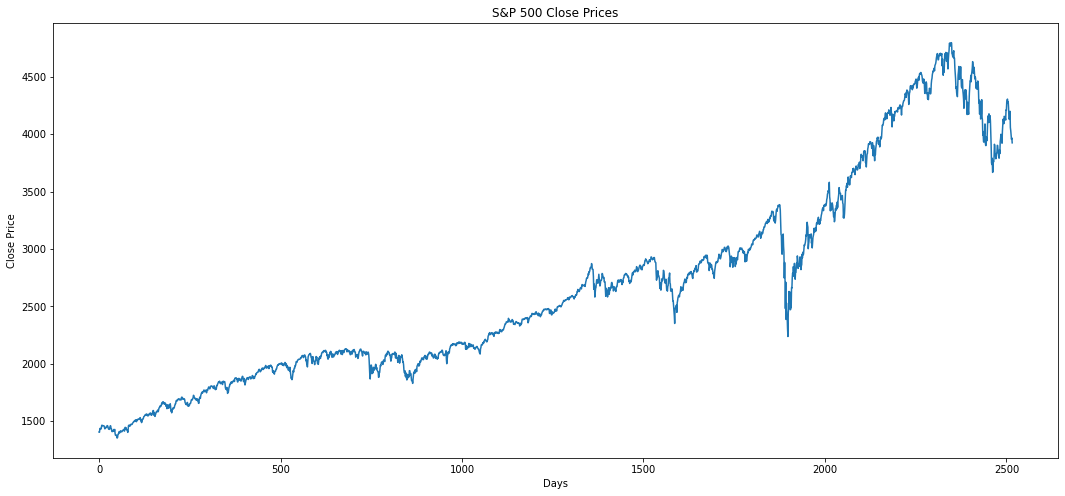

In [54]:
stock_names = ["^GSPC"]
all_train_data =[]
all_validation_data =[]

gspc = yf.Ticker(stock_names[0])
stock_df = gspc.history(period="10y")
stock_df.index.name = "Date"
stock_df = stock_df.sort_values('Date')
#stock_df['Close'] = stock_df['Close'].apply(lambda x: float(x.replace(',', '')))
#stock_df['Volume'] = stock_df['Volume'].apply(lambda x: float(x.replace(',', '')))

print("stock_df.shape: ", stock_df.shape)

data = stock_df
#print(data)
df = pd.DataFrame(data, columns = ['Open','High','Low','Close','Volume'])
df = df.reset_index(level=0)
display(df)
data = df

plt.figure(figsize=(18, 8))
plt.plot(range(df.shape[0]), df['Close'], )
plt.title("S&P 500 Close Prices")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.show()

In [55]:
length_data = len(data)     # rows that data has
split_ratio = 0.8           # %80 train + %20 validation + test
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 2517
Train data length : 2014
Validation data lenth : 503


In [56]:
train_data = data[:length_train].iloc[:,[0, 4]] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Close
0,2012-09-04,1404.939941
1,2012-09-05,1403.439941
2,2012-09-06,1432.119995
3,2012-09-07,1437.920044
4,2012-09-10,1429.079956
...,...,...
2009,2020-08-28,3508.010010
2010,2020-08-31,3500.310059
2011,2020-09-01,3526.649902
2012,2020-09-02,3580.840088


In [57]:
validation_data = data[length_train:].iloc[:,[0, 4]]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
print(validation_data.shape)
validation_data

(503, 2)


,Date,Close
2014,2020-09-04,3426.959961
2015,2020-09-08,3331.840088
2016,2020-09-09,3398.959961
2017,2020-09-10,3339.189941
2018,2020-09-11,3340.969971
...,...,...
2512,2022-08-29,4030.610107
2513,2022-08-30,3986.159912
2514,2022-08-31,3955.000000
2515,2022-09-01,3966.850098


In [58]:
dataset_train = train_data.Close.values
dataset_train.shape

(2014,)

In [59]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(2014, 1)

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(2014, 1)

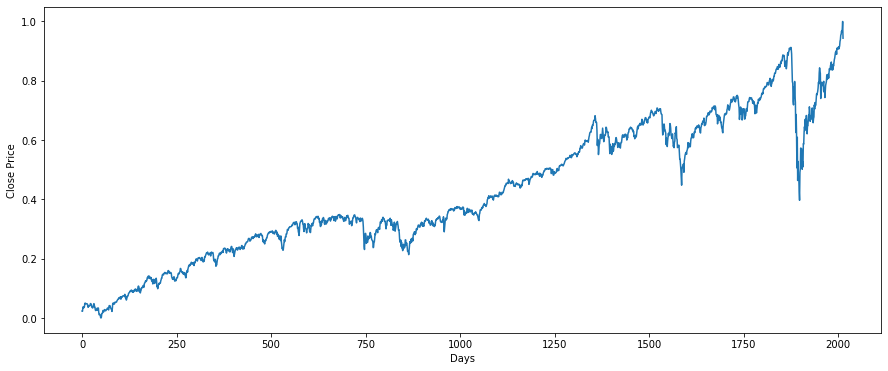

In [61]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.show()

In [62]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1964, 50)
Shape of y_train before reshape : (1964,)


In [63]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :", X_train.shape)
print("Shape of y_train after reshape :", y_train.shape)

Shape of X_train after reshape : (1964, 50, 1)
Shape of y_train after reshape : (1964, 1)


In [ ]:
# Code for 1 layer RNN
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
RNN1 = Sequential()

# adding first RNN layer and dropout regulatization
RNN1.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1], 1))
             )

RNN1.add(
    Dropout(0.2)
             )

# adding second RNN layer
RNN1.add(
    SimpleRNN(units = 50)
             )

RNN1.add(
    Dropout(0.2)
             )

# adding the output layer
RNN1.add(Dense(units = 1))

# compiling RNN
RNN1.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

RNNhistory1 = RNN1.fit(X_train, y_train, validation_split = 0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 1s 14ms/step - loss: 0.1134 - accuracy: 5.6593e-04 - val_loss: 0.0029 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0254 - accuracy: 5.6593e-04 - val_loss: 0.0089 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 1s 10ms/step - loss: 0.0136 - accuracy: 5.6593e-04 - val_loss: 0.0022 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0105 - accuracy: 5.6593e-04 - val_loss: 0.0018 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0081 - accuracy: 5.6593e-04 - val_loss: 0.0020 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0066 - accuracy: 5.6593e-04 - val_loss: 0.0019 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0053 - accuracy: 5.6593e-04 - val_loss: 0.0016 -

In [117]:
# initializing the RNN
RNN1_medium = Sequential()

# adding first RNN layer and dropout regulatization
RNN1_medium.add(
    SimpleRNN(units = 256, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1], 1))
             )

RNN1_medium.add(
    Dropout(0.2)
             )

# adding second RNN layer
RNN1_medium.add(
    SimpleRNN(units = 256)
             )

RNN1_medium.add(
    Dropout(0.2)
             )

# adding the output layer
RNN1_medium.add(Dense(units = 1))

# compiling RNN
RNN1_medium.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

RNNhistory1_medium = RNN1_medium.fit(X_train, y_train, validation_split = 0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 4s 66ms/step - loss: 0.2268 - accuracy: 5.6593e-04 - val_loss: 0.0096 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 4s 63ms/step - loss: 0.0195 - accuracy: 5.6593e-04 - val_loss: 0.0087 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 4s 63ms/step - loss: 0.0111 - accuracy: 5.6593e-04 - val_loss: 0.0043 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 4s 63ms/step - loss: 0.0069 - accuracy: 5.6593e-04 - val_loss: 0.0050 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 4s 63ms/step - loss: 0.0061 - accuracy: 5.6593e-04 - val_loss: 0.0033 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 4s 63ms/step - loss: 0.0052 - accuracy: 5.6593e-04 - val_loss: 0.0030 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 3s 62ms/step - loss: 0.0047 - accuracy: 5.6593e-04 - val_loss: 0.0024 -

In [49]:
# Code for 1  layer with LR decay RNN
# initializing the RNN
RNN1_LR_decay = Sequential()

# adding first RNN layer and dropout regulatization
RNN1_LR_decay.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

RNN1_LR_decay.add(
    Dropout(0.2)
             )

# adding second RNN layer and dropout regulatization
RNN1_LR_decay.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

RNN1_LR_decay.add(
    Dropout(0.2)
             )

# adding the output layer
RNN1_LR_decay.add(Dense(units = 1))

# compiling RNN
RNN1_LR_decay.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

callback = callbacks.LearningRateScheduler(lr_time_based_decay)

RNNhistory1_LR_decay = RNN1_LR_decay.fit(X_train, y_train, validation_split = 0.1, epochs = 100, batch_size = 32, callbacks=[callback])

Epoch 1/100
56/56 [==============================] - 2s 14ms/step - loss: 0.0654 - accuracy: 5.6593e-04 - val_loss: 0.0197 - val_accuracy: 0.0050 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0122 - accuracy: 5.6593e-04 - val_loss: 0.0189 - val_accuracy: 0.0051 - lr: 9.9990e-04
Epoch 3/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0074 - accuracy: 5.6593e-04 - val_loss: 0.0184 - val_accuracy: 0.0051 - lr: 9.9970e-04
Epoch 4/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0056 - accuracy: 5.6593e-04 - val_loss: 0.0184 - val_accuracy: 0.0051 - lr: 9.9940e-04
Epoch 5/100
56/56 [==============================] - 1s 10ms/step - loss: 0.0047 - accuracy: 5.6593e-04 - val_loss: 0.0191 - val_accuracy: 0.0051 - lr: 9.9900e-04
Epoch 6/100
56/56 [==============================] - 1s 10ms/step - loss: 0.0040 - accuracy: 5.6593e-04 - val_loss: 0.0182 - val_accuracy: 0.0051 - lr: 9.9850e-04
Epoch 7/100
56/56 [=======

In [50]:
# Code for 2 layer RNN
# initializing the RNN
RNN2 = Sequential()

# adding first RNN layer and dropout regulatization
RNN2.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

RNN2.add(
    Dropout(0.2)
             )

# adding second RNN layer and dropout regulatization
RNN2.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

RNN2.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization
RNN2.add(
    SimpleRNN(units = 50)
             )

RNN2.add(
    Dropout(0.2)
             )

# adding the output layer
RNN2.add(Dense(units = 1))

# compiling RNN
RNN2.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

RNNhistory2 = RNN2.fit(X_train, y_train, validation_split = 0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 2s 19ms/step - loss: 0.2251 - accuracy: 5.6593e-04 - val_loss: 0.0100 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0880 - accuracy: 5.6593e-04 - val_loss: 0.0032 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0524 - accuracy: 5.6593e-04 - val_loss: 0.0045 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0391 - accuracy: 5.6593e-04 - val_loss: 0.0032 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0238 - accuracy: 5.6593e-04 - val_loss: 0.0059 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0182 - accuracy: 5.6593e-04 - val_loss: 0.0015 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0153 - accuracy: 5.6593e-04 - val_loss: 0.0014 -

In [110]:
# Code for 2 layer RNN
# initializing the RNN
RNN2_medium = Sequential()

# adding first RNN layer and dropout regulatization
RNN2_medium.add(
    SimpleRNN(units = 256, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

RNN2_medium.add(
    Dropout(0.2)
             )

# adding second RNN layer and dropout regulatization
RNN2_medium.add(
    SimpleRNN(units = 256, 
              activation = "tanh", 
              return_sequences = True)
             )

RNN2_medium.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization
RNN2_medium.add(
    SimpleRNN(units = 256)
             )

RNN2_medium.add(
    Dropout(0.2)
             )

# adding the output layer
RNN2_medium.add(Dense(units = 1))

# compiling RNN
RNN2_medium.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

RNNhistory2_medium = RNN2_medium.fit(X_train, y_train, validation_split = 0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 7s 103ms/step - loss: 0.7635 - accuracy: 0.0000e+00 - val_loss: 0.5682 - val_accuracy: 0.0000e+00
Epoch 2/100
56/56 [==============================] - 6s 101ms/step - loss: 0.4262 - accuracy: 0.0000e+00 - val_loss: 0.1537 - val_accuracy: 0.0000e+00
Epoch 3/100
56/56 [==============================] - 6s 99ms/step - loss: 0.3884 - accuracy: 5.6593e-04 - val_loss: 0.0297 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 6s 100ms/step - loss: 0.3061 - accuracy: 5.6593e-04 - val_loss: 0.0137 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 6s 98ms/step - loss: 0.2832 - accuracy: 5.6593e-04 - val_loss: 0.3230 - val_accuracy: 0.0000e+00
Epoch 6/100
56/56 [==============================] - 6s 101ms/step - loss: 0.2654 - accuracy: 5.6593e-04 - val_loss: 0.1596 - val_accuracy: 0.0000e+00
Epoch 7/100
56/56 [==============================] - 6s 100ms/step - loss: 0.2308 - accuracy: 0.0000e+00

In [51]:
# Code for 2 layer with LR decay RNN
# initializing the RNN
RNN2_LR_decay = Sequential()

# adding first RNN layer and dropout regulatization
RNN2_LR_decay.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

RNN2_LR_decay.add(
    Dropout(0.2)
             )

# adding second RNN layer and dropout regulatization
RNN2_LR_decay.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

RNN2_LR_decay.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization
RNN2_LR_decay.add(
    SimpleRNN(units = 50)
             )

RNN2_LR_decay.add(
    Dropout(0.2)
             )

# adding the output layer
RNN2_LR_decay.add(Dense(units = 1))

# compiling RNN
RNN2_LR_decay.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

callback = callbacks.LearningRateScheduler(lr_time_based_decay)

RNNhistory2_LR_decay = RNN2_LR_decay.fit(X_train, y_train, validation_split = 0.1, epochs = 100, batch_size = 32, callbacks=[callback])

Epoch 1/100
56/56 [==============================] - 2s 19ms/step - loss: 0.2034 - accuracy: 5.6593e-04 - val_loss: 0.0059 - val_accuracy: 0.0051 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 1s 15ms/step - loss: 0.0575 - accuracy: 5.6593e-04 - val_loss: 0.0034 - val_accuracy: 0.0051 - lr: 9.9990e-04
Epoch 3/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0348 - accuracy: 5.6593e-04 - val_loss: 0.0027 - val_accuracy: 0.0051 - lr: 9.9970e-04
Epoch 4/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0271 - accuracy: 5.6593e-04 - val_loss: 0.0114 - val_accuracy: 0.0051 - lr: 9.9940e-04
Epoch 5/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0201 - accuracy: 5.6593e-04 - val_loss: 0.0022 - val_accuracy: 0.0051 - lr: 9.9900e-04
Epoch 6/100
56/56 [==============================] - 1s 16ms/step - loss: 0.0155 - accuracy: 5.6593e-04 - val_loss: 0.0097 - val_accuracy: 0.0051 - lr: 9.9850e-04
Epoch 7/100
56/56 [=======

In [64]:
y_pred = RNN1.predict(X_train)  # predictions
print(y_pred.shape)
y_pred1 = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred1.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

(1964, 1)


(1964, 1)

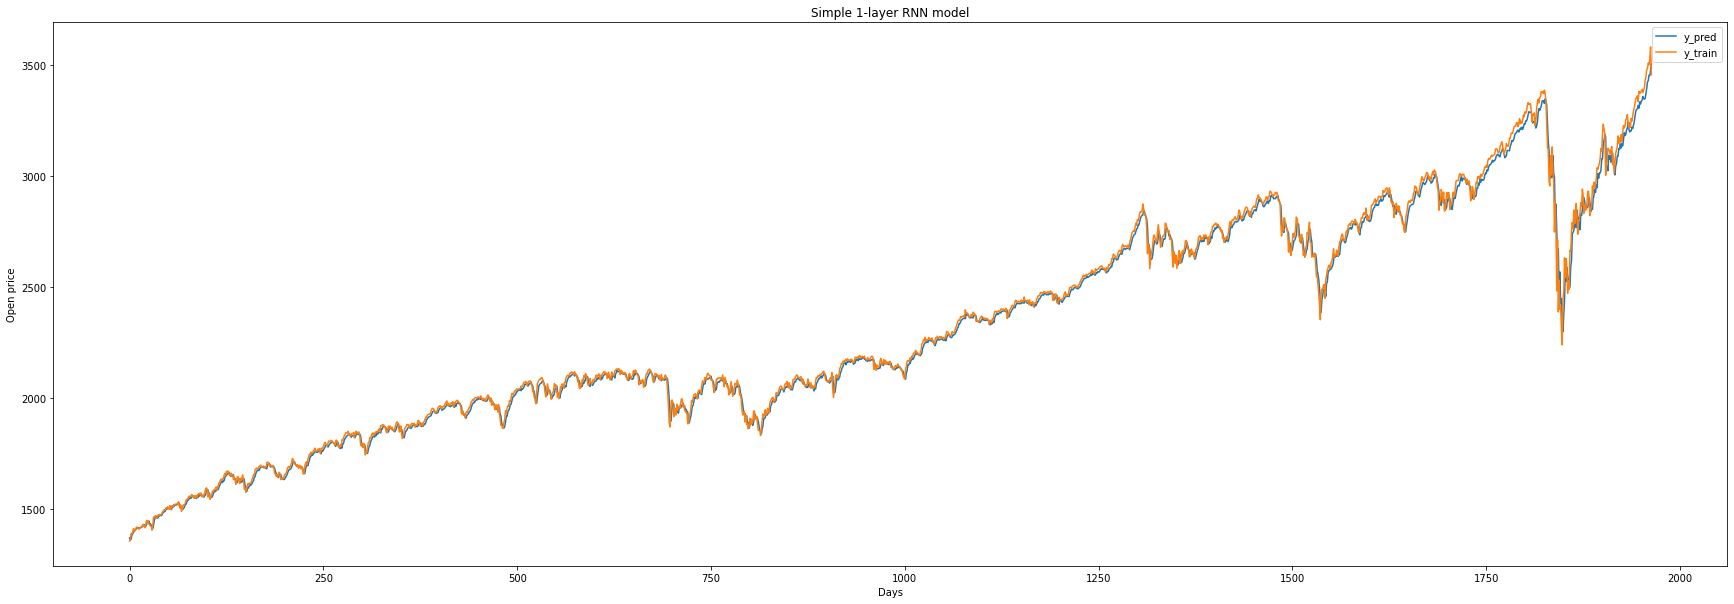

In [65]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred1, label = "y_pred" )
plt.plot(y_train_scaled, label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 1-layer RNN model")
plt.legend()
plt.show()

In [66]:
y_pred = RNN2.predict(X_train)  # predictions
print(y_pred.shape)
y_pred2 = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred2.shape

#y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
#y_train_scaled.shape

(1964, 1)


(1964, 1)

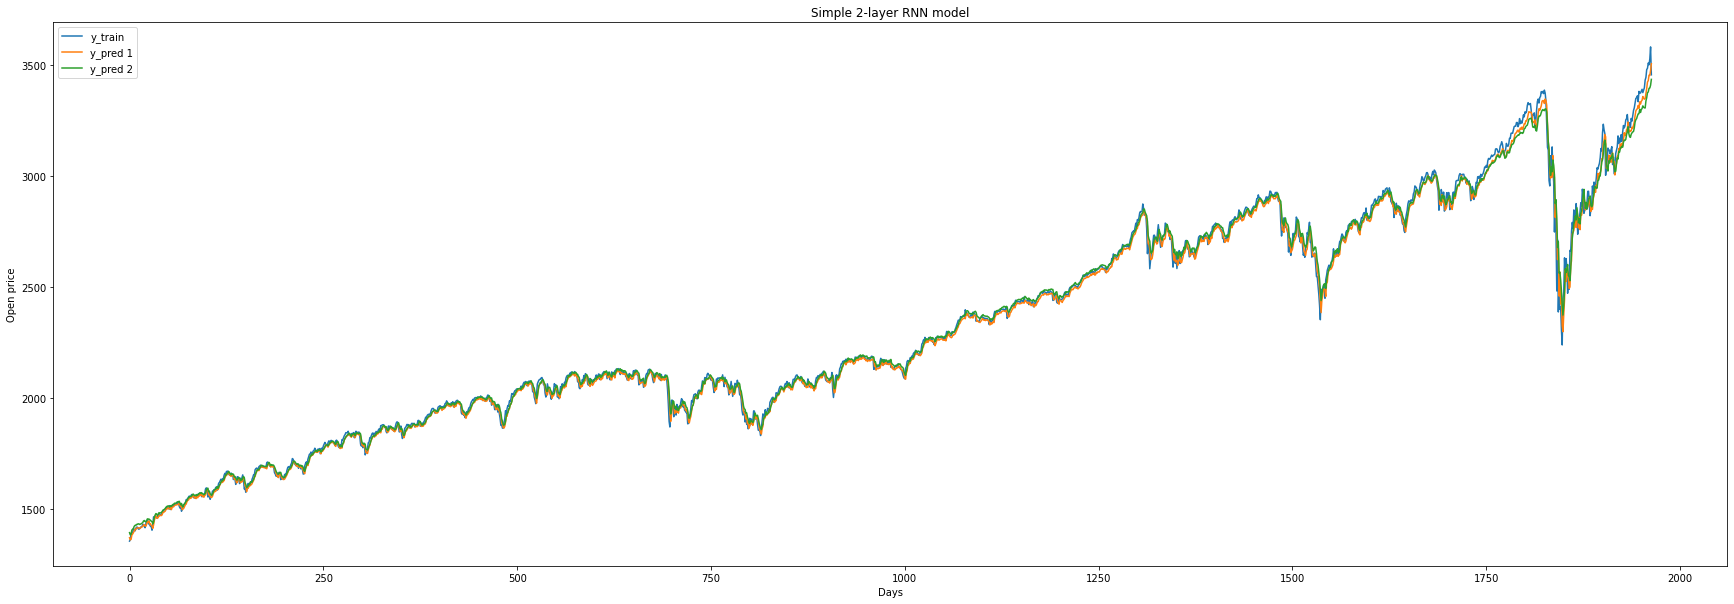

In [67]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_pred2, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

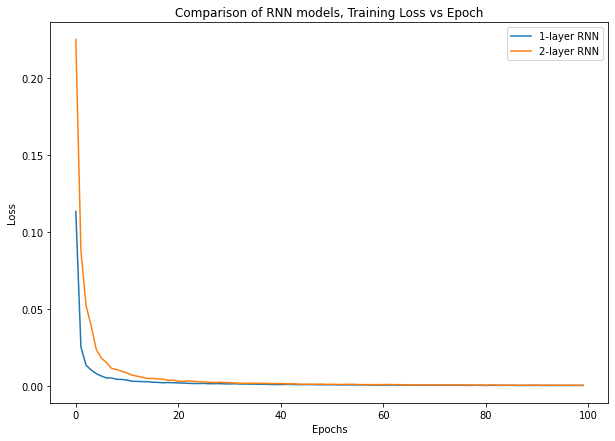

In [68]:
plt.figure(figsize =(10,7))
plt.plot(RNNhistory1.history["loss"], label = '1-layer RNN')
plt.plot(RNNhistory2.history["loss"], label = '2-layer RNN')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of RNN models, Training Loss vs Epoch")
plt.show()

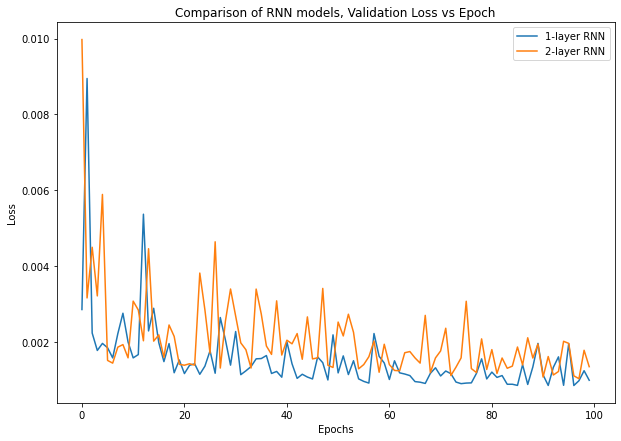

In [69]:
plt.figure(figsize =(10,7))
plt.plot(RNNhistory1.history["val_loss"], label = '1-layer RNN')
plt.plot(RNNhistory2.history["val_loss"], label = '2-layer RNN')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of RNN models, Validation Loss vs Epoch")
plt.show()

In [70]:
y_train = scaler.fit_transform(y_train)

In [71]:
from keras.layers import LSTM

lstm1 = Sequential()

#Inpput layer
lstm1.add(
    LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm1.add(Dropout(rate=0.2))

#Output layer
lstm1.add(
    LSTM(50, return_sequences= False))

lstm1.add(Dense(32))
lstm1.add(Dense(1))

lstm1.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory1 = lstm1.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 4s 30ms/step - loss: 0.0146 - accuracy: 5.6593e-04 - val_loss: 0.0056 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 1s 21ms/step - loss: 5.8801e-04 - accuracy: 5.6593e-04 - val_loss: 0.0046 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 1s 21ms/step - loss: 5.6074e-04 - accuracy: 5.6593e-04 - val_loss: 0.0046 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 1s 21ms/step - loss: 5.1527e-04 - accuracy: 5.6593e-04 - val_loss: 0.0050 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 1s 21ms/step - loss: 5.1803e-04 - accuracy: 5.6593e-04 - val_loss: 0.0044 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 1s 21ms/step - loss: 4.9347e-04 - accuracy: 5.6593e-04 - val_loss: 0.0041 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 1s 21ms/step - loss: 4.6700e-04 - accuracy: 5.6593e

In [72]:
from keras.layers import LSTM

lstm1_medium = Sequential()

#Inpput layer
lstm1_medium.add(
    LSTM(256,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm1_medium.add(Dropout(rate=0.2))

#Output layer
lstm1_medium.add(
    LSTM(256, return_sequences= False))

lstm1_medium.add(Dense(32))
lstm1_medium.add(Dense(1))

lstm1_medium.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory1_medium = lstm1_medium.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 11s 162ms/step - loss: 0.0088 - accuracy: 5.6593e-04 - val_loss: 0.0026 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 9s 154ms/step - loss: 3.1839e-04 - accuracy: 5.6593e-04 - val_loss: 0.0029 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 9s 155ms/step - loss: 3.4364e-04 - accuracy: 5.6593e-04 - val_loss: 0.0025 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 9s 156ms/step - loss: 3.2739e-04 - accuracy: 5.6593e-04 - val_loss: 0.0028 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 9s 155ms/step - loss: 3.2454e-04 - accuracy: 5.6593e-04 - val_loss: 0.0026 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 9s 155ms/step - loss: 3.0576e-04 - accuracy: 5.6593e-04 - val_loss: 0.0024 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 9s 155ms/step - loss: 3.2716e-04 - accuracy:

In [73]:
from keras.layers import LSTM

lstm1_large = Sequential()

#Inpput layer
lstm1_large.add(
    LSTM(512,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm1_large.add(Dropout(rate=0.2))

#Output layer
lstm1_large.add(
    LSTM(512, return_sequences= False))

lstm1_large.add(Dense(32))
lstm1_large.add(Dense(1))

lstm1_large.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory1_large = lstm1_large.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 30s 497ms/step - loss: 0.0091 - accuracy: 5.6593e-04 - val_loss: 0.0023 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 27s 490ms/step - loss: 2.7838e-04 - accuracy: 5.6593e-04 - val_loss: 0.0023 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 27s 491ms/step - loss: 2.6916e-04 - accuracy: 5.6593e-04 - val_loss: 0.0020 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 27s 491ms/step - loss: 2.3502e-04 - accuracy: 5.6593e-04 - val_loss: 0.0020 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 28s 496ms/step - loss: 2.2956e-04 - accuracy: 5.6593e-04 - val_loss: 0.0021 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 27s 491ms/step - loss: 2.3656e-04 - accuracy: 5.6593e-04 - val_loss: 0.0017 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 28s 493ms/step - loss: 2.2780e-04 - acc

In [74]:

lstm1_LR_decay = Sequential()

#Inpput layer
lstm1_LR_decay.add(
    LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm1_LR_decay.add(Dropout(rate=0.2))

#Output layer
lstm1_LR_decay.add(
    LSTM(50, return_sequences= False))

lstm1_LR_decay.add(Dense(32))
lstm1_LR_decay.add(Dense(1))

initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

callback = callbacks.LearningRateScheduler(lr_time_based_decay)

lstm1_LR_decay.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory1_LR_decay = lstm1_LR_decay.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32, callbacks=[callback])

Epoch 1/100
56/56 [==============================] - 4s 29ms/step - loss: 0.0198 - accuracy: 5.6593e-04 - val_loss: 0.0047 - val_accuracy: 0.0051 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 1s 21ms/step - loss: 5.6984e-04 - accuracy: 5.6593e-04 - val_loss: 0.0046 - val_accuracy: 0.0051 - lr: 9.9990e-04
Epoch 3/100
56/56 [==============================] - 1s 21ms/step - loss: 5.7813e-04 - accuracy: 5.6593e-04 - val_loss: 0.0046 - val_accuracy: 0.0051 - lr: 9.9970e-04
Epoch 4/100
56/56 [==============================] - 1s 21ms/step - loss: 5.2132e-04 - accuracy: 5.6593e-04 - val_loss: 0.0047 - val_accuracy: 0.0051 - lr: 9.9940e-04
Epoch 5/100
56/56 [==============================] - 1s 21ms/step - loss: 5.3318e-04 - accuracy: 5.6593e-04 - val_loss: 0.0044 - val_accuracy: 0.0051 - lr: 9.9900e-04
Epoch 6/100
56/56 [==============================] - 1s 21ms/step - loss: 4.7006e-04 - accuracy: 5.6593e-04 - val_loss: 0.0046 - val_accuracy: 0.0051 - lr: 9.9850e-04
Epoch 

In [75]:

from keras.layers import LSTM

lstm2 = Sequential()

#Input layer
lstm2.add(
    LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm2.add(Dropout(rate=0.2))

#First hidden layer
lstm2.add(
    LSTM(50,return_sequences=True)) #64 lstm neuron block
lstm2.add(Dropout(rate=0.2))

#Output layer
lstm2.add(
    LSTM(50, return_sequences= False))

lstm2.add(Dense(32))
lstm2.add(Dense(1))

lstm2.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory2 = lstm2.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 5s 43ms/step - loss: 0.0107 - accuracy: 5.6593e-04 - val_loss: 0.0092 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 2s 31ms/step - loss: 9.4926e-04 - accuracy: 5.6593e-04 - val_loss: 0.0078 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 2s 31ms/step - loss: 8.3357e-04 - accuracy: 5.6593e-04 - val_loss: 0.0066 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 2s 31ms/step - loss: 7.6976e-04 - accuracy: 5.6593e-04 - val_loss: 0.0066 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 2s 31ms/step - loss: 7.2775e-04 - accuracy: 5.6593e-04 - val_loss: 0.0062 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 2s 31ms/step - loss: 7.7353e-04 - accuracy: 5.6593e-04 - val_loss: 0.0061 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 2s 31ms/step - loss: 6.8731e-04 - accuracy: 5.6593e

In [76]:

from keras import callbacks

lstm2_medium = Sequential()

#Input layer
lstm2_medium.add(
    LSTM(256,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm2_medium.add(Dropout(rate=0.2))

#First hidden layer
lstm2_medium.add(
    LSTM(256,return_sequences=True)) #64 lstm neuron block
lstm2_medium.add(Dropout(rate=0.2))

#Output layer
lstm2_medium.add(
    LSTM(256, return_sequences= False))

lstm2_medium.add(Dense(32))
lstm2_medium.add(Dense(1))

lstm2_medium.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory2_medium = lstm2_medium.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 17s 258ms/step - loss: 0.0056 - accuracy: 5.6593e-04 - val_loss: 0.0042 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 14s 242ms/step - loss: 5.2136e-04 - accuracy: 5.6593e-04 - val_loss: 0.0040 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 14s 244ms/step - loss: 6.5278e-04 - accuracy: 5.6593e-04 - val_loss: 0.0038 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 14s 244ms/step - loss: 4.6176e-04 - accuracy: 5.6593e-04 - val_loss: 0.0037 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 14s 248ms/step - loss: 4.9167e-04 - accuracy: 5.6593e-04 - val_loss: 0.0035 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 14s 245ms/step - loss: 4.6659e-04 - accuracy: 5.6593e-04 - val_loss: 0.0033 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 14s 245ms/step - loss: 4.6866e-04 - acc

In [77]:

from keras import callbacks

lstm2_large = Sequential()

#Input layer
lstm2_large.add(
    LSTM(512,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm2_large.add(Dropout(rate=0.2))

#First hidden layer
lstm2_large.add(
    LSTM(512,return_sequences=True)) #64 lstm neuron block
lstm2_large.add(Dropout(rate=0.2))

#Output layer
lstm2_large.add(
    LSTM(512, return_sequences= False))

lstm2_large.add(Dense(32))
lstm2_large.add(Dense(1))

lstm2_large.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory2_large = lstm2_large.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 47s 791ms/step - loss: 0.0216 - accuracy: 5.6593e-04 - val_loss: 0.0087 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 44s 789ms/step - loss: 4.6741e-04 - accuracy: 5.6593e-04 - val_loss: 0.0036 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 44s 785ms/step - loss: 3.6580e-04 - accuracy: 5.6593e-04 - val_loss: 0.0041 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 43s 767ms/step - loss: 3.7445e-04 - accuracy: 5.6593e-04 - val_loss: 0.0035 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 43s 764ms/step - loss: 4.1000e-04 - accuracy: 5.6593e-04 - val_loss: 0.0039 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 43s 764ms/step - loss: 3.5034e-04 - accuracy: 5.6593e-04 - val_loss: 0.0031 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 43s 763ms/step - loss: 4.4302e-04 - acc

In [78]:

from keras.layers import LSTM

lstm2_LR_decay = Sequential()

#Input layer
lstm2_LR_decay.add(
    LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm2_LR_decay.add(Dropout(rate=0.2))

#First hidden layer
lstm2_LR_decay.add(
    LSTM(50,return_sequences=True)) #64 lstm neuron block
lstm2_LR_decay.add(Dropout(rate=0.2))

#Output layer
lstm2_LR_decay.add(
    LSTM(50, return_sequences= False))

lstm2_LR_decay.add(Dense(32))
lstm2_LR_decay.add(Dense(1))

initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

callback = callbacks.LearningRateScheduler(lr_time_based_decay)
lstm2_LR_decay.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory2_LR_decay = lstm2_LR_decay.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32, callbacks=[callback])

Epoch 1/100
56/56 [==============================] - 5s 45ms/step - loss: 0.0111 - accuracy: 5.6593e-04 - val_loss: 0.0071 - val_accuracy: 0.0051 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 2s 32ms/step - loss: 8.1319e-04 - accuracy: 5.6593e-04 - val_loss: 0.0066 - val_accuracy: 0.0051 - lr: 9.9990e-04
Epoch 3/100
56/56 [==============================] - 2s 32ms/step - loss: 8.1295e-04 - accuracy: 5.6593e-04 - val_loss: 0.0072 - val_accuracy: 0.0051 - lr: 9.9970e-04
Epoch 4/100
56/56 [==============================] - 2s 32ms/step - loss: 7.2764e-04 - accuracy: 5.6593e-04 - val_loss: 0.0062 - val_accuracy: 0.0051 - lr: 9.9940e-04
Epoch 5/100
56/56 [==============================] - 2s 31ms/step - loss: 6.8478e-04 - accuracy: 5.6593e-04 - val_loss: 0.0065 - val_accuracy: 0.0051 - lr: 9.9900e-04
Epoch 6/100
56/56 [==============================] - 2s 31ms/step - loss: 7.8117e-04 - accuracy: 5.6593e-04 - val_loss: 0.0060 - val_accuracy: 0.0051 - lr: 9.9850e-04
Epoch 

In [79]:

from keras import callbacks

lstm3 = Sequential()

#Input layer
lstm3.add(
    LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm3.add(Dropout(rate=0.2))

#First hidden layer
lstm3.add(
    LSTM(50,return_sequences=True)) #64 lstm neuron block
lstm3.add(Dropout(rate=0.2))

#Second hidden layer
lstm3.add(
    LSTM(50,return_sequences=True)) #64 lstm neuron block
lstm3.add(Dropout(rate=0.2))

#Output layer
lstm3.add(
    LSTM(50, return_sequences= False))

lstm3.add(Dense(32))
lstm3.add(Dense(1))

lstm3.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory3 = lstm3.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 7s 58ms/step - loss: 0.0149 - accuracy: 5.6593e-04 - val_loss: 0.0103 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 2s 42ms/step - loss: 0.0010 - accuracy: 5.6593e-04 - val_loss: 0.0104 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 2s 41ms/step - loss: 0.0011 - accuracy: 5.6593e-04 - val_loss: 0.0096 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 2s 41ms/step - loss: 9.4176e-04 - accuracy: 5.6593e-04 - val_loss: 0.0102 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 2s 41ms/step - loss: 9.7544e-04 - accuracy: 5.6593e-04 - val_loss: 0.0095 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 2s 41ms/step - loss: 9.2047e-04 - accuracy: 5.6593e-04 - val_loss: 0.0091 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 2s 41ms/step - loss: 9.1385e-04 - accuracy: 5.6593e-04 - va

In [80]:

from keras import callbacks

lstm3_medium = Sequential()

#Input layer
lstm3_medium.add(
    LSTM(256,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm3_medium.add(Dropout(rate=0.2))

#First hidden layer
lstm3_medium.add(
    LSTM(256,return_sequences=True)) #64 lstm neuron block
lstm3_medium.add(Dropout(rate=0.2))

#Second hidden layer
lstm3_medium.add(
    LSTM(256,return_sequences=True)) #64 lstm neuron block
lstm3_medium.add(Dropout(rate=0.2))

#Output layer
lstm3_medium.add(
    LSTM(256, return_sequences= False))

lstm3_medium.add(Dense(32))
lstm3_medium.add(Dense(1))

lstm3_medium.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory3_medium = lstm3_medium.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 26s 394ms/step - loss: 0.0367 - accuracy: 5.6593e-04 - val_loss: 0.0085 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 21s 367ms/step - loss: 6.9895e-04 - accuracy: 5.6593e-04 - val_loss: 0.0083 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 21s 376ms/step - loss: 7.2852e-04 - accuracy: 5.6593e-04 - val_loss: 0.0076 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 20s 363ms/step - loss: 6.7883e-04 - accuracy: 5.6593e-04 - val_loss: 0.0094 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 21s 374ms/step - loss: 7.8291e-04 - accuracy: 5.6593e-04 - val_loss: 0.0074 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 21s 374ms/step - loss: 6.4712e-04 - accuracy: 5.6593e-04 - val_loss: 0.0068 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 20s 356ms/step - loss: 7.1757e-04 - acc

In [81]:

from keras import callbacks

lstm3_large = Sequential()

#Input layer
lstm3_large.add(
    LSTM(512,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm3_large.add(Dropout(rate=0.2))

#First hidden layer
lstm3_large.add(
    LSTM(512,return_sequences=True)) #64 lstm neuron block
lstm3_large.add(Dropout(rate=0.2))

#Second hidden layer
lstm3_large.add(
    LSTM(512,return_sequences=True)) #64 lstm neuron block
lstm3_large.add(Dropout(rate=0.2))

#Output layer
lstm3_large.add(
    LSTM(512, return_sequences= False))

lstm3_large.add(Dense(32))
lstm3_large.add(Dense(1))

lstm3_large.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory3_large = lstm3_large.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32)

Epoch 1/100
56/56 [==============================] - 73s 1s/step - loss: 0.0239 - accuracy: 5.6593e-04 - val_loss: 0.0061 - val_accuracy: 0.0051
Epoch 2/100
56/56 [==============================] - 64s 1s/step - loss: 4.8586e-04 - accuracy: 5.6593e-04 - val_loss: 0.0053 - val_accuracy: 0.0051
Epoch 3/100
56/56 [==============================] - 64s 1s/step - loss: 6.5662e-04 - accuracy: 5.6593e-04 - val_loss: 0.0058 - val_accuracy: 0.0051
Epoch 4/100
56/56 [==============================] - 64s 1s/step - loss: 5.6013e-04 - accuracy: 5.6593e-04 - val_loss: 0.0045 - val_accuracy: 0.0051
Epoch 5/100
56/56 [==============================] - 66s 1s/step - loss: 5.4572e-04 - accuracy: 5.6593e-04 - val_loss: 0.0042 - val_accuracy: 0.0051
Epoch 6/100
56/56 [==============================] - 65s 1s/step - loss: 4.8679e-04 - accuracy: 5.6593e-04 - val_loss: 0.0054 - val_accuracy: 0.0051
Epoch 7/100
56/56 [==============================] - 67s 1s/step - loss: 5.3220e-04 - accuracy: 5.6593e-04 - v

In [82]:

from keras import callbacks

lstm3_LR_decay = Sequential()

#Input layer
lstm3_LR_decay.add(
    LSTM(50,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
lstm3_LR_decay.add(Dropout(rate=0.2))

#First hidden layer
lstm3_LR_decay.add(
    LSTM(50,return_sequences=True)) #64 lstm neuron block
lstm3_LR_decay.add(Dropout(rate=0.2))

#Second hidden layer
lstm3_LR_decay.add(
    LSTM(50,return_sequences=True)) #64 lstm neuron block
lstm3_LR_decay.add(Dropout(rate=0.2))

#Output layer
lstm3_LR_decay.add(
    LSTM(50, return_sequences= False))

lstm3_LR_decay.add(Dense(32))
lstm3_LR_decay.add(Dense(1))

initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

callback = callbacks.LearningRateScheduler(lr_time_based_decay)
lstm3_LR_decay.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
LSTMhistory3_LR_decay = lstm3_LR_decay.fit(X_train, y_train, validation_split=0.1, epochs = 100, batch_size = 32, callbacks=[callback])

Epoch 1/100
56/56 [==============================] - 8s 71ms/step - loss: 0.0131 - accuracy: 5.6593e-04 - val_loss: 0.0100 - val_accuracy: 0.0051 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 3s 50ms/step - loss: 0.0011 - accuracy: 5.6593e-04 - val_loss: 0.0099 - val_accuracy: 0.0051 - lr: 9.9990e-04
Epoch 3/100
56/56 [==============================] - 3s 50ms/step - loss: 9.8143e-04 - accuracy: 5.6593e-04 - val_loss: 0.0097 - val_accuracy: 0.0051 - lr: 9.9970e-04
Epoch 4/100
56/56 [==============================] - 3s 50ms/step - loss: 9.2930e-04 - accuracy: 5.6593e-04 - val_loss: 0.0092 - val_accuracy: 0.0051 - lr: 9.9940e-04
Epoch 5/100
56/56 [==============================] - 3s 49ms/step - loss: 9.7116e-04 - accuracy: 5.6593e-04 - val_loss: 0.0092 - val_accuracy: 0.0051 - lr: 9.9900e-04
Epoch 6/100
56/56 [==============================] - 3s 49ms/step - loss: 0.0011 - accuracy: 5.6593e-04 - val_loss: 0.0120 - val_accuracy: 0.0051 - lr: 9.9850e-04
Epoch 7/100
56

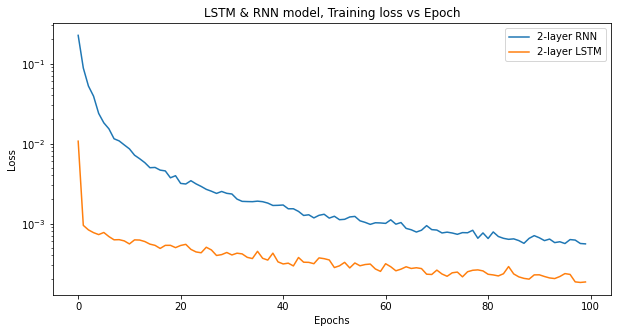

In [99]:
plt.figure(figsize =(10,5))
plt.yscale('log')
plt.plot(RNNhistory2.history["loss"], label = '2-layer RNN')
plt.plot(LSTMhistory2.history["loss"], label = '2-layer LSTM')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM & RNN model, Training loss vs Epoch")
plt.show()

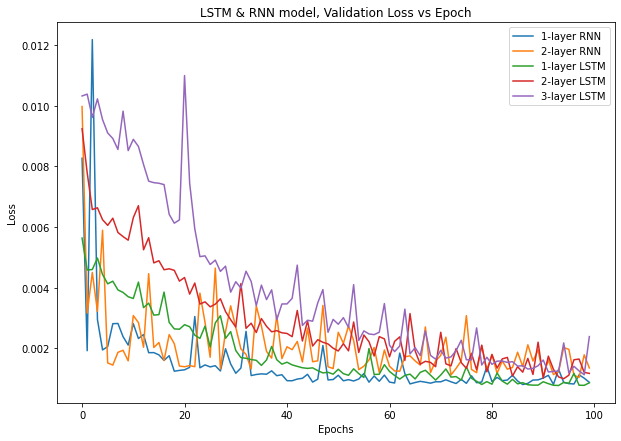

In [167]:
plt.figure(figsize =(10,7))
plt.plot(RNNhistory1.history["val_loss"], label = '1-layer RNN')
plt.plot(RNNhistory2.history["val_loss"], label = '2-layer RNN')
plt.plot(LSTMhistory1.history["val_loss"], label = '1-layer LSTM')
plt.plot(LSTMhistory2.history["val_loss"], label = '2-layer LSTM')
plt.plot(LSTMhistory3.history["val_loss"], label = '3-layer LSTM')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM & RNN model, Validation Loss vs Epoch")
plt.show()

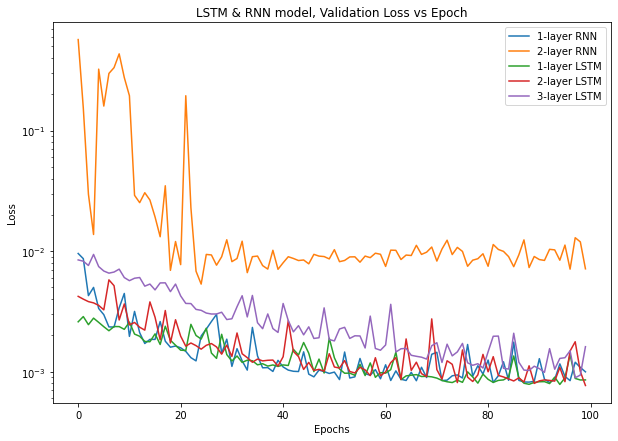

In [166]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory1_medium.history["val_loss"], label = '1-layer RNN')
plt.plot(RNNhistory2_medium.history["val_loss"], label = '2-layer RNN')
plt.plot(LSTMhistory1_medium.history["val_loss"], label = '1-layer LSTM')
plt.plot(LSTMhistory2_medium.history["val_loss"], label = '2-layer LSTM')
plt.plot(LSTMhistory3_medium.history["val_loss"], label = '3-layer LSTM')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM & RNN model, Validation Loss vs Epoch")
plt.show()

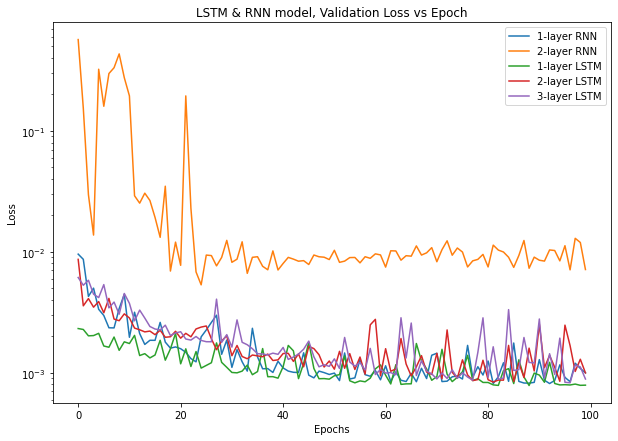

In [168]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory1_medium.history["val_loss"], label = '1-layer RNN')
plt.plot(RNNhistory2_medium.history["val_loss"], label = '2-layer RNN')
plt.plot(LSTMhistory1_large.history["val_loss"], label = '1-layer LSTM')
plt.plot(LSTMhistory2_large.history["val_loss"], label = '2-layer LSTM')
plt.plot(LSTMhistory3_large.history["val_loss"], label = '3-layer LSTM')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM & RNN model, Validation Loss vs Epoch")
plt.show()

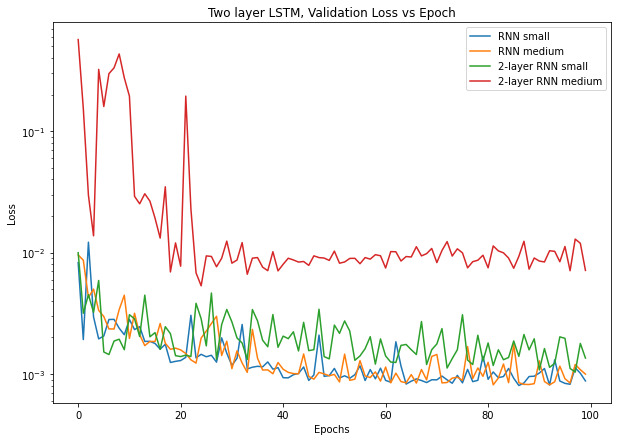

In [154]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory1.history["val_loss"], label = 'RNN small')
plt.plot(RNNhistory1_medium.history["val_loss"], label = 'RNN medium')
plt.plot(RNNhistory2.history["val_loss"], label = '2-layer RNN small')
plt.plot(RNNhistory2_medium.history["val_loss"], label = '2-layer RNN medium')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two layer LSTM, Validation Loss vs Epoch")
plt.show()

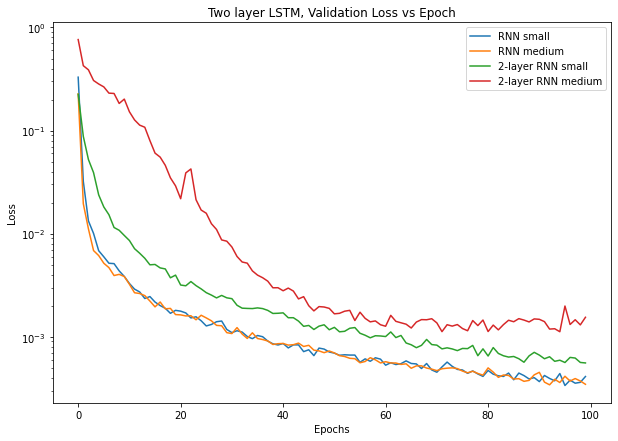

In [155]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory1.history["loss"], label = 'RNN small')
plt.plot(RNNhistory1_medium.history["loss"], label = 'RNN medium')
plt.plot(RNNhistory2.history["loss"], label = '2-layer RNN small')
plt.plot(RNNhistory2_medium.history["loss"], label = '2-layer RNN medium')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two layer LSTM, Validation Loss vs Epoch")
plt.show()

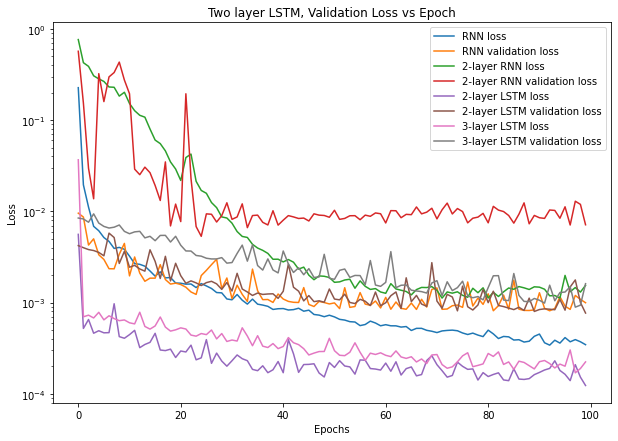

In [159]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory1_medium.history["loss"], label = 'RNN loss')
plt.plot(RNNhistory1_medium.history["val_loss"], label = 'RNN validation loss')
plt.plot(RNNhistory2_medium.history["loss"], label = '2-layer RNN loss')
plt.plot(RNNhistory2_medium.history["val_loss"], label = '2-layer RNN validation loss')
plt.plot(LSTMhistory2_medium.history["loss"], label = '2-layer LSTM loss')
plt.plot(LSTMhistory2_medium.history["val_loss"], label = '2-layer LSTM validation loss')
plt.plot(LSTMhistory3_medium.history["loss"], label = '3-layer LSTM loss')
plt.plot(LSTMhistory3_medium.history["val_loss"], label = '3-layer LSTM validation loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two layer LSTM, Validation Loss vs Epoch")
plt.show()

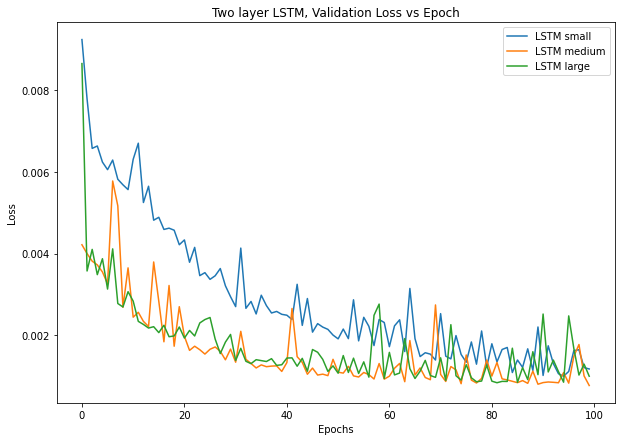

In [145]:
plt.figure(figsize =(10,7))
plt.plot(LSTMhistory2.history["val_loss"], label = 'LSTM small')
plt.plot(LSTMhistory2_medium.history["val_loss"], label = 'LSTM medium')
plt.plot(LSTMhistory2_large.history["val_loss"], label = 'LSTM large')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Two layer LSTM, Validation Loss vs Epoch")
plt.show()

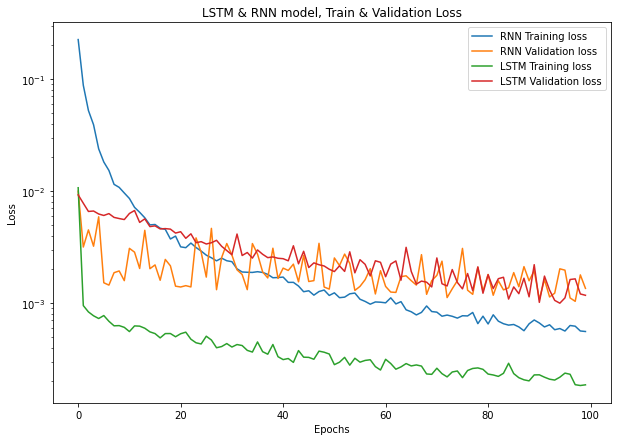

In [147]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory2.history["loss"], label = 'RNN Training loss')
plt.plot(RNNhistory2.history["val_loss"], label = 'RNN Validation loss')
plt.plot(LSTMhistory2.history["loss"], label = 'LSTM Training loss')
plt.plot(LSTMhistory2.history["val_loss"], label = 'LSTM Validation loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM & RNN model, Train & Validation Loss")
plt.show()

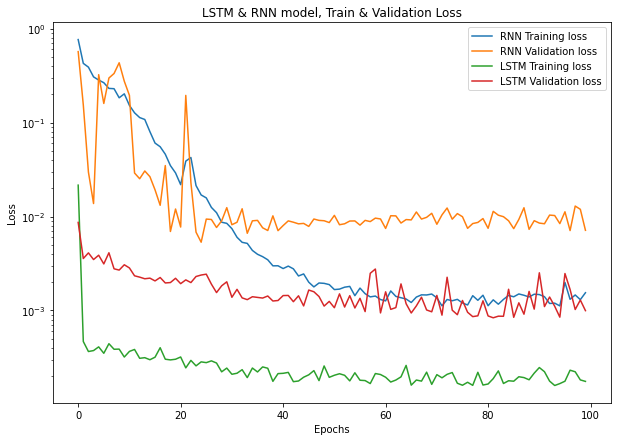

In [146]:
plt.figure(figsize =(10,7))
plt.yscale('log')
plt.plot(RNNhistory2_medium.history["loss"], label = 'RNN Training loss')
plt.plot(RNNhistory2_medium.history["val_loss"], label = 'RNN Validation loss')
plt.plot(LSTMhistory2_large.history["loss"], label = 'LSTM Training loss')
plt.plot(LSTMhistory2_large.history["val_loss"], label = 'LSTM Validation loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM & RNN model, Train & Validation Loss")
plt.show()

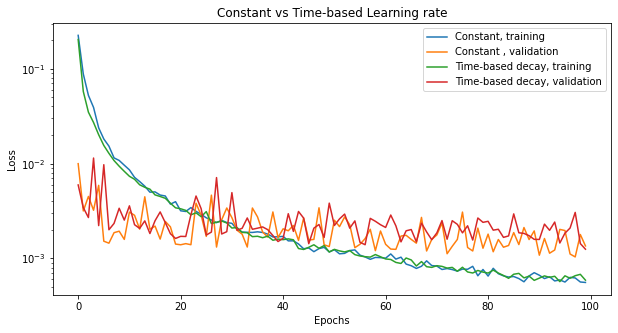

In [101]:
plt.figure(figsize =(10,5))
plt.yscale('log')
plt.plot(RNNhistory2.history["loss"], label = 'Constant, training')
plt.plot(RNNhistory2.history["val_loss"], label = 'Constant , validation')
plt.plot(RNNhistory2_LR_decay.history["loss"], label = 'Time-based decay, training')
plt.plot(RNNhistory2_LR_decay.history["val_loss"], label = 'Time-based decay, validation')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Constant vs Time-based Learning rate")
plt.show()

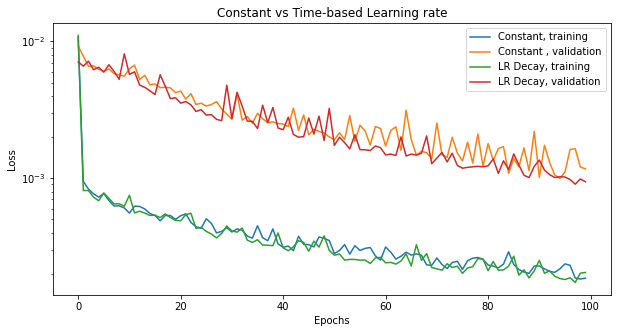

In [91]:
plt.figure(figsize =(10,5))
plt.yscale('log')
plt.plot(LSTMhistory2.history["loss"], label = 'Constant, training')
plt.plot(LSTMhistory2.history["val_loss"], label = 'Constant , validation')
plt.plot(LSTMhistory2_LR_decay.history["loss"], label = 'LR Decay, training')
plt.plot(LSTMhistory2_LR_decay.history["val_loss"], label = 'LR Decay, validation')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Constant vs Time-based Learning rate")
plt.show()

(1964, 1)


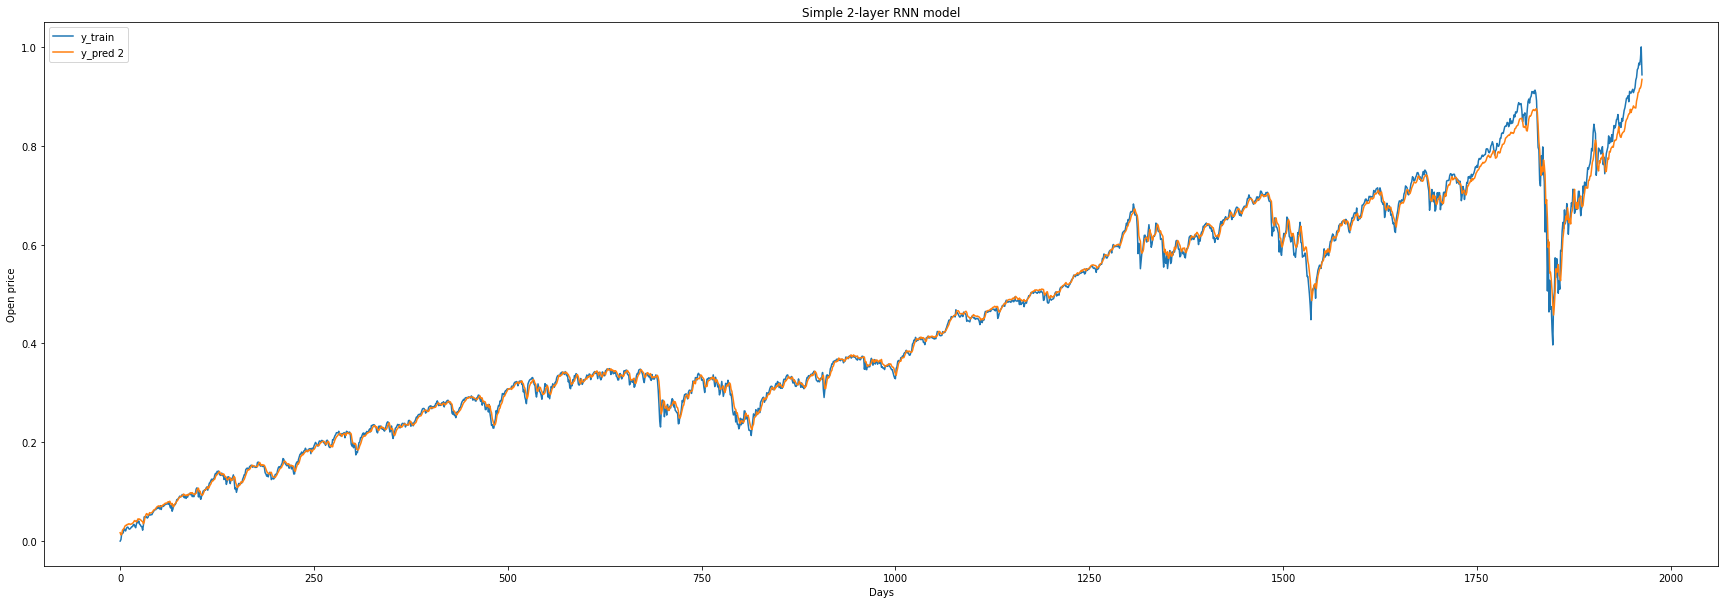

In [143]:
y_pred = RNN2.predict(X_train)  # predictions
print(y_pred.shape)
y_pred2 = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred2.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_pred2, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

(1964, 1)


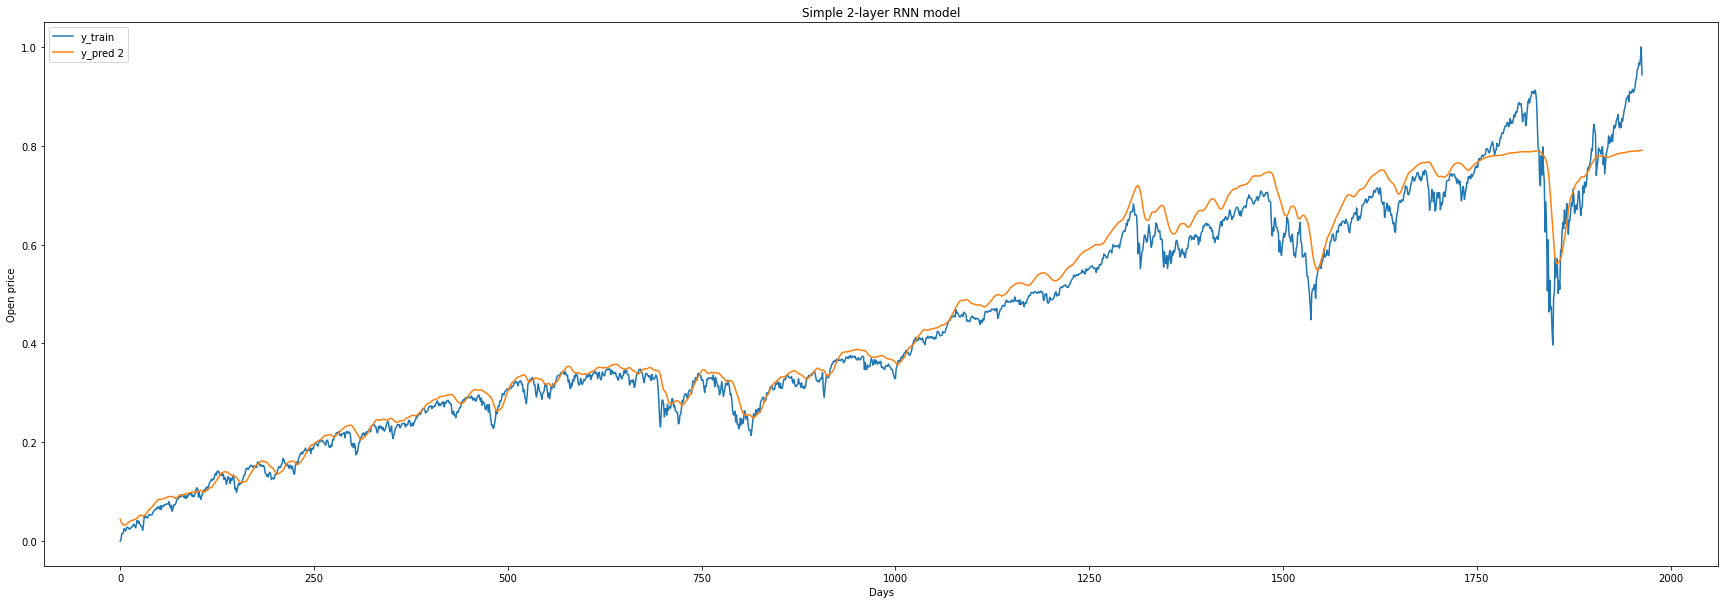

In [142]:
y_pred = RNN2_medium.predict(X_train)  # predictions
print(y_pred.shape)
y_pred2_medium = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred2_medium.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_pred2_medium, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

(1964, 1)


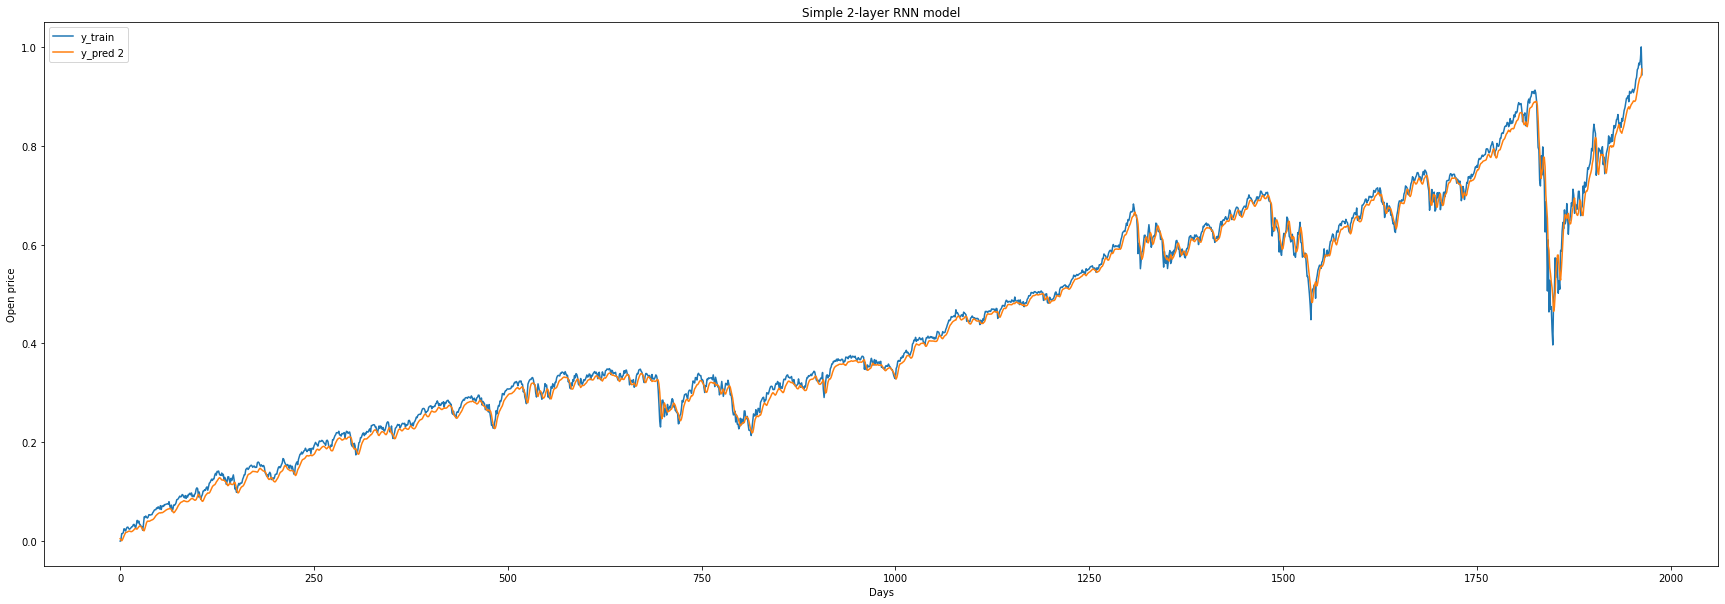

In [141]:
y_pred = lstm2.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM2 = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM2.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM2, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

In [161]:
LSTMhistory2.history["loss"]

[0.010705721564590931,
 0.0009492610697634518,
 0.0008335723541676998,
 0.0007697605178691447,
 0.0007277494296431541,
 0.0007735320832580328,
 0.0006873107049614191,
 0.0006263660034164786,
 0.0006290597375482321,
 0.000606871210038662,
 0.0005563322338275611,
 0.0006250953883863986,
 0.0006221854710020125,
 0.0005960809648968279,
 0.0005531684728339314,
 0.000533932528924197,
 0.0004887335235252976,
 0.0005339010385796428,
 0.0005344297969713807,
 0.0005002316320315003,
 0.0005321942735463381,
 0.0005496313679032028,
 0.00047553240437991917,
 0.00044196913950145245,
 0.00043126349919475615,
 0.0005056403460912406,
 0.0004678199766203761,
 0.0003989750111941248,
 0.0004090127767995,
 0.000434755434980616,
 0.00040499764145351946,
 0.0004261792346369475,
 0.00041759145096875727,
 0.0003780981933232397,
 0.0003651757724583149,
 0.0004495539178606123,
 0.00036798205110244453,
 0.0003494847915135324,
 0.00042652126285247505,
 0.00033195578726008534,
 0.0003127578820567578,
 0.000319780840

In [162]:
LSTMhistory2_medium.history["loss"]

[0.005595682188868523,
 0.000521360372658819,
 0.0006527776131406426,
 0.0004617607919499278,
 0.0004916659672744572,
 0.00046659194049425423,
 0.0004686581960413605,
 0.0009718697401694953,
 0.00042384659172967076,
 0.00040674186311662197,
 0.00044562239781953394,
 0.0004965870175510645,
 0.00032085293787531555,
 0.00034773946390487254,
 0.0003667581477202475,
 0.0004607251030392945,
 0.0003023835306521505,
 0.0002978217671625316,
 0.00030901000718586147,
 0.0002503043506294489,
 0.0002948927867691964,
 0.0002877714578062296,
 0.00034189497819170356,
 0.00023606391914654523,
 0.0002481445553712547,
 0.00039292796282097697,
 0.0002160686271963641,
 0.0002796561748255044,
 0.00022878714662510902,
 0.0002009784075198695,
 0.00023059012892190367,
 0.0002668583474587649,
 0.0002427245635772124,
 0.00023085132124833763,
 0.00018548732623457909,
 0.0001793944975361228,
 0.00020296835282351822,
 0.0001705477334326133,
 0.00018359872046858072,
 0.00022622081451117992,
 0.00017045166168827564,


In [163]:
LSTMhistory2_large.history["loss"]

[0.02155805192887783,
 0.00046740940888412297,
 0.0003658028144855052,
 0.0003744453133549541,
 0.0004100027435924858,
 0.0003503364569041878,
 0.00044301862362772226,
 0.00038664796738885343,
 0.00038812862476333976,
 0.00031962667708285153,
 0.0003668349818326533,
 0.00038481387309730053,
 0.00030979272560216486,
 0.00031456362921744585,
 0.0002992156078107655,
 0.00031831039814278483,
 0.0004015227605123073,
 0.0003029407234862447,
 0.000297887105261907,
 0.0003027629863936454,
 0.0003199651837348938,
 0.0002450251195114106,
 0.00029437802731990814,
 0.00025742745492607355,
 0.0002838387154042721,
 0.00027854988002218306,
 0.00029101292602717876,
 0.0002759592025540769,
 0.00022243378043640405,
 0.0002437309449305758,
 0.00020951304759364575,
 0.0002148460189346224,
 0.0002344593231100589,
 0.0001930270082084462,
 0.00024402749841101468,
 0.00022169071598909795,
 0.00025088273105211556,
 0.00024270416179206222,
 0.00017616279365029186,
 0.00021288616699166596,
 0.0002144463651347905

In [164]:
LSTMhistory3_medium.history["loss"]

[0.03674280270934105,
 0.0006989509565755725,
 0.0007285198080353439,
 0.0006788279279135168,
 0.0007829139940440655,
 0.0006471158703789115,
 0.0007175736245699227,
 0.0006679677753709257,
 0.0006338524981401861,
 0.000645410967990756,
 0.0006009071948938072,
 0.0005843279650434852,
 0.0007846053340472281,
 0.000548117037396878,
 0.0005124190938659012,
 0.0005549031775444746,
 0.0006955000571906567,
 0.000539208936970681,
 0.00048707672976888716,
 0.000503040908370167,
 0.0005288902320899069,
 0.0005135465180501342,
 0.00044060838990844786,
 0.00042874497012235224,
 0.0004580973763950169,
 0.0004457916656974703,
 0.0005008446169085801,
 0.0004001331399194896,
 0.0004579509259201586,
 0.0003751222975552082,
 0.00038908381247892976,
 0.000379120756406337,
 0.0005294503644108772,
 0.0004300552245695144,
 0.0003370799822732806,
 0.0004336840065661818,
 0.0003332637425046414,
 0.00032201953581534326,
 0.00035562700941227376,
 0.0003131311677861959,
 0.00033057268592529,
 0.0004138565564062

In [165]:
LSTMhistory3_large.history["loss"]

[0.023926133289933205,
 0.00048585663898847997,
 0.0006566210649907589,
 0.0005601270240731537,
 0.0005457202205434442,
 0.0004867867683060467,
 0.0005321986973285675,
 0.0004769420193042606,
 0.0004476777103263885,
 0.0004887688555754721,
 0.00044341542525216937,
 0.00040217008790932596,
 0.0004277876578271389,
 0.00046530645340681076,
 0.00037829895154573023,
 0.00036030274350196123,
 0.00039713323349133134,
 0.000280162290437147,
 0.00029225280741229653,
 0.00034059028257615864,
 0.0002951208152808249,
 0.0004523888055700809,
 0.0002725308295339346,
 0.0002634303236845881,
 0.0003727115399669856,
 0.0002948363544419408,
 0.0003134321013931185,
 0.00028814160032197833,
 0.0003755534125957638,
 0.00035219622077420354,
 0.00025397687568329275,
 0.00028619859949685633,
 0.0003449901123531163,
 0.00029637981788255274,
 0.0002475169312674552,
 0.0003491709940135479,
 0.0002444374840706587,
 0.0002384691033512354,
 0.00024148396914824843,
 0.00026291568065062165,
 0.00024095697153825313,
 

(1964, 1)


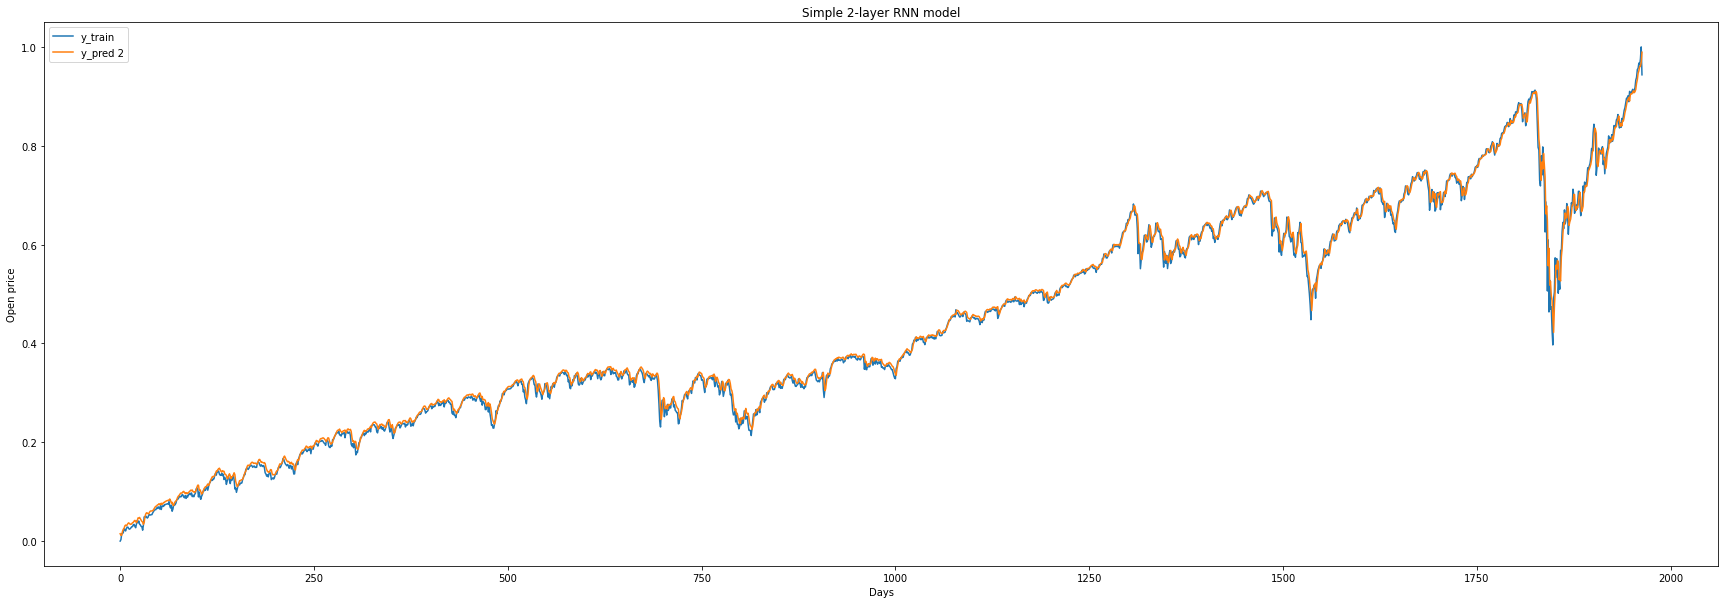

In [140]:
y_pred = lstm2_medium.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM2_medium = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM2_medium.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM2_medium, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

(1964, 1)


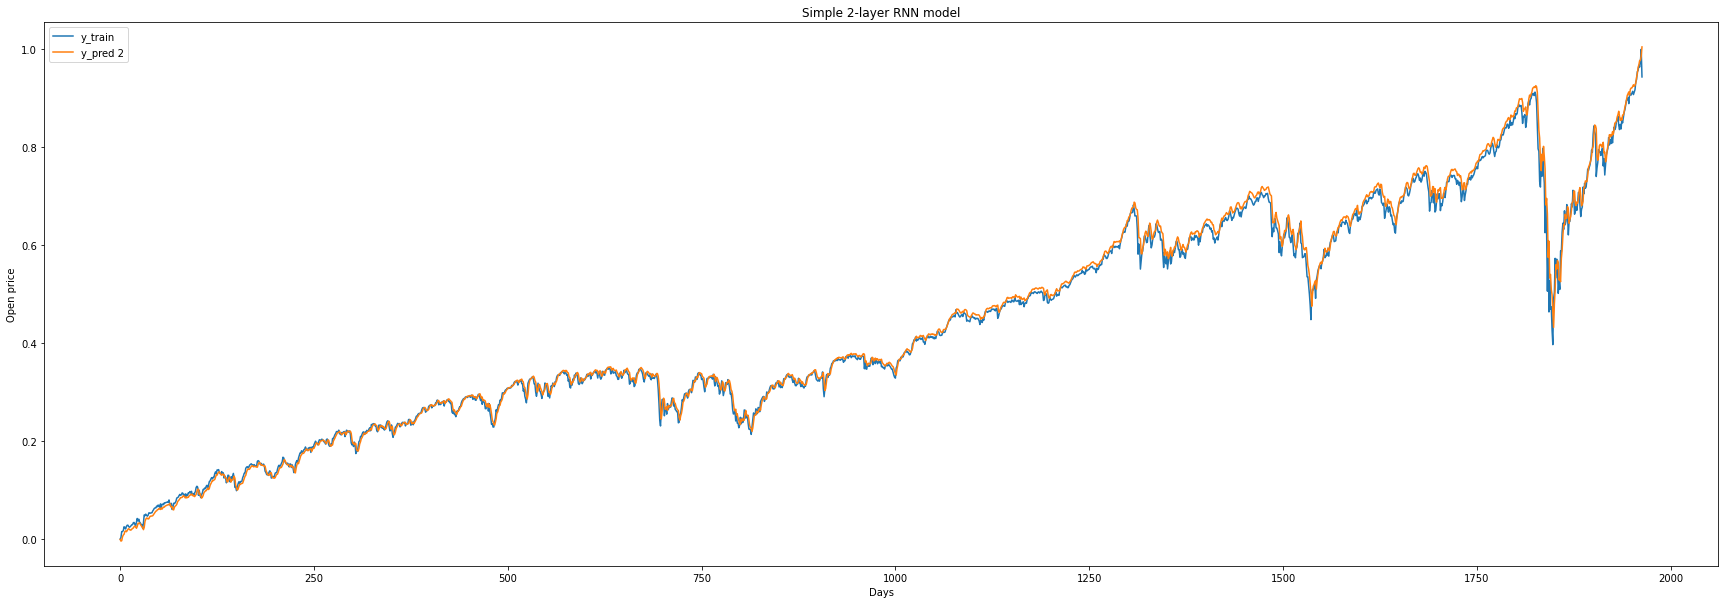

In [136]:
y_pred = lstm2_large.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM2_large = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM2_large.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM2_large, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

(1964, 1)


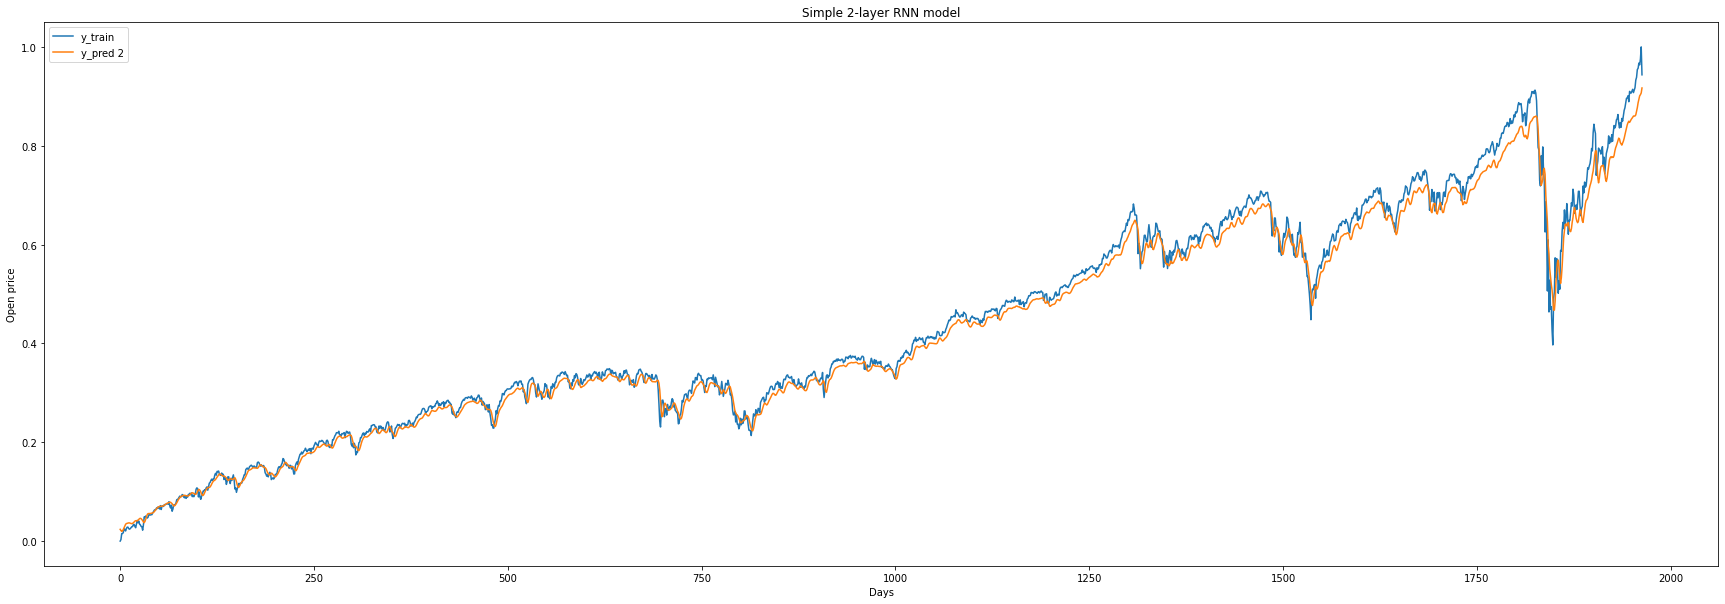

In [137]:
y_pred = lstm3.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM3 = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM3.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM3, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple 2-layer RNN model")
plt.legend()
plt.show()

In [170]:
# serialize model to JSON
model_json = lstm1_large.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm1_large.save_weights("model.h5")

In [199]:
# serialize model to JSON
model = RNN2_LR_decay
model_json = model.to_json()
with open("RNN2_LR_decay.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

Loaded model from disk
(1964, 1)


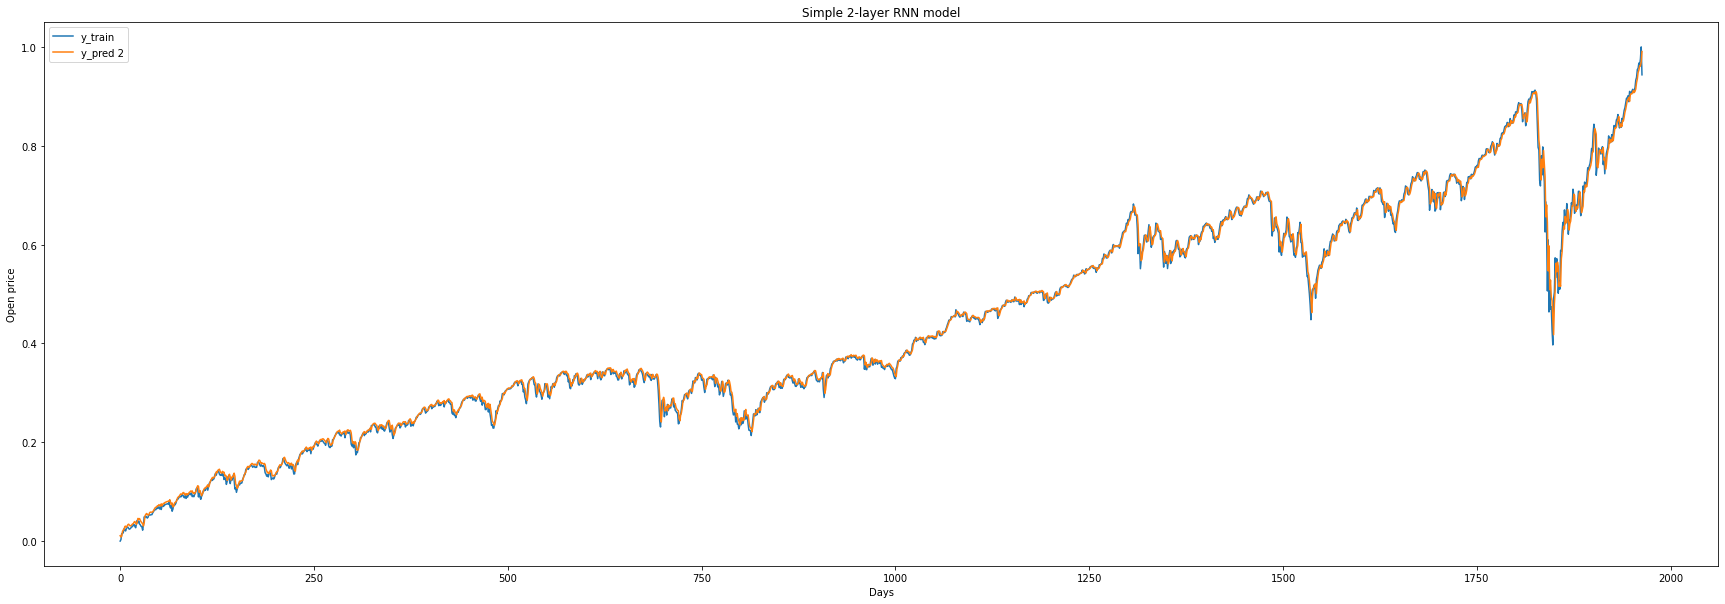

In [173]:
from tensorflow.keras.models import Sequential, model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
y_pred = loaded_model.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM3_loaded = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM3_loaded.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM3_loaded, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("2-layer LSTM model")
plt.legend()
plt.show()

In [2]:
from tensorflow.keras.models import Sequential, model_from_json

# load json and create model
json_file = open('lstm2_large.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
y_pred = loaded_model.predict(X_train)  # predictions
print(y_pred.shape)
y_predLSTM3_loaded = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_predLSTM3_loaded.shape

y_train_scaled = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train_scaled.shape

# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_train_scaled, label = "y_train")
#plt.plot(y_pred1, label = "y_pred 1" )
plt.plot(y_predLSTM3_loaded, label = "y_pred 2" )
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("2-layer LSTM model")
plt.legend()
plt.show()

ValueError: Layer count mismatch when loading weights from file. Model expected 5 layers, found 4 saved layers.